# Time series analysis with HyP3 and MintPy

This notebook walks through performing a time-series analysis for Mt. Edgecumbe, Alaska with On Demand InSAR products from the Alaska Satellite facility and MintPy. It follows the methodology of
[Grapenthin et. al., 2022]( https://doi.org/10.1029/2022GL099464) who used an InSAR time series analysis to identify volcanic activity in the area. In this notebook we'll:

1. Use the [ASF Search Python package](https://docs.asf.alaska.edu/asf_search/basics/) to:
   - Search ASF's catalog for Sentinel-1 SAR products covering the [Ridgecrest earthquake](https://earthquake.usgs.gov/storymap/index-ridgecrest.html)
   - Select a reference scene to generate a baseline stack
   - Select a [short baseline subset (SBAS)](https://docs.asf.alaska.edu/vertex/sbas/) of scene pairs for InSAR processing


2. Use the [HyP3 Python SDK](https://hyp3-docs.asf.alaska.edu/using/sdk/) to:
   - Request On Demand InSAR products from ASF HyP3
   - Download the InSAR products when they are done processing


3. Use [GDAL](https://gdal.org/api/index.html#python-api) and [MintPy](https://mintpy.readthedocs.io/en/latest/) to:
   - Prepare the InSAR products for MintPy
   - perform a time-series analysis with MintPy
   
---

**Note:** This notebook does assume you have some familiarity with InSAR processing with MintPy already, and is a minimal example without much context or explanations. If you're new to InSAR and MintPy, I suggest checking out:
* our [InSAR on Demand Story Map](https://storymaps.arcgis.com/stories/68a8a3253900411185ae9eb6bb5283d3)


* [OpenSARlab's](https://opensarlab-docs.asf.alaska.edu/) highly detailed walkthrough of using HyP3 + MintPy via these notebooks:
  * [Prepare a HyP3 InSAR Stack for MintPy](https://nbviewer.org/github/ASFOpenSARlab/opensarlab-notebooks/blob/master/SAR_Training/English/Master/Prepare_HyP3_InSAR_Stack_for_MintPy.ipynb)
  * [MintPy Time-series Analysis](https://nbviewer.org/github/ASFOpenSARlab/opensarlab-notebooks/blob/master/SAR_Training/English/Master/MintPy_Time_Series_From_Prepared_Data_Stack.ipynb)
  
    Note: While these notebooks make some assumptions you're working in OpenSARlab, you can run these 
    notebooks outside OpenSARlab by creating [this conda environment](https://github.com/ASFOpenSARlab/opensarlab-envs/blob/main/Environment_Configs/insar_analysis_env.yml).

## 0. Initial Setup

To run this notebook, you'll need a conda environment with the required dependencies. You can set up a new environment (recommended) and run the jupyter server like:
```shell
conda create -n hyp3-mintpy python=3.8 asf_search hyp3_sdk "mintpy>=1.3.2" pandas jupyter ipympl

conda activate hyp3-mintpy
jupyter notebook igarss_mtedgecumbe_ts_analysis.ipynb
```
Or, install these dependencies into your own environment:
```shell
conda install hyp3-mintpy python=3.8 asf_search hyp3_sdk "mintpy>=1.3.2" pandas jupyter ipympl

jupyter notebook igarss_mtedgecumbe_ts_analysis.ipynb
```

Then we'll start the data processing

First import the needed modules and set up our processing directories

In [6]:
import utils
import numpy as np
from datetime import datetime
from pathlib import Path

import hyp3_sdk as sdk
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data_dir = Path('./data')
if not data_dir.exists():
    data_dir.mkdir()

work_dir = Path('./mintpy')
if not work_dir.exists():
    work_dir.mkdir()

weather_dir = Path('./weather')
if not weather_dir.exists():
    weather_dir.mkdir()

## 1. Load Pair List

We are getting pair lists from the [supplementary information](https://zenodo.org/record/7151431) published by Grapenthin et. al.. Take a look at the `utils.py` script in the same directory as this notebook to see how we're doing this.

In [3]:
utils.get_edgecumbe_insar_pairs()

In [4]:
project_name = 'edgecumbe_descending_174'
project_name += f'_{datetime.now().strftime("%Y%m%dT%H:%M")}'
pair_list = pd.read_csv('DESCENDING_174_pairs_smaller.csv', parse_dates=[0,1]).sort_values('date1').reset_index(drop=True)

sbas_pairs = list(zip(list(pair_list['scene1']), list(pair_list['scene2'])))

In snowy areas like Mt. Edgecumbe, the use of a normal Small Baseline Subset (SBAS) network for Interferometric Synthetic Aperture Radar (InSAR) analysis may encounter certain limitations, particularly during the winter season. The presence of snow on the ground introduces significant decorrelation effects that hinder the accurate measurement of surface displacements. As a result, interferograms generated during winter periods tend to be unreliable and less informative. To overcome this challenge, it becomes necessary to exclude interferograms from the winter season. However, excluding winter interferograms leaves a data gap that can hamper the continuity of monitoring. To address this issue, an alternative approach is to create longer baseline interferograms, which span over a longer period of time and cover the missing winter period. By extending the baseline length, it becomes possible to capture a larger temporal span, allowing for a more comprehensive analysis of surface deformation, despite the limitations imposed by the snowy conditions. See the graph below to see the network that Grapenthin et. al. used.

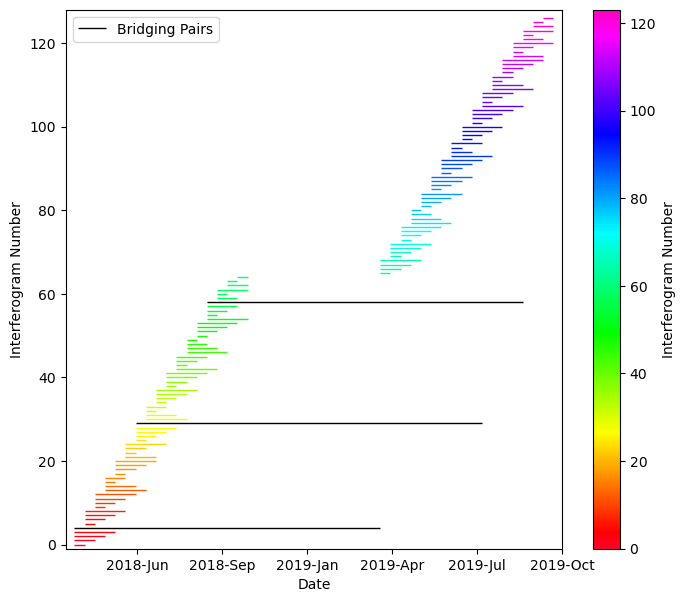

In [7]:
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection

lines = []
bridges =[]
for i, row in pair_list.iterrows():
    point1 = [mdates.date2num(row['date1']), i]
    point2 = [mdates.date2num(row['date2']), i]
    if point2[0] - point1[0] > 48:
        bridges.append([point1, point2])
    else:
        lines.append([point1, point2])


f, ax = plt.subplots(1,1,figsize=(8,7))
line_segments = LineCollection(lines, array=range(len(lines)), linewidths=1, cmap='gist_rainbow')
bridge_segments = LineCollection(bridges, color='black', linewidths=1, label='Bridging Pairs')
ax.add_collection(line_segments)
ax.add_collection(bridge_segments)
axcb = f.colorbar(line_segments)
axcb.set_label('Interferogram Number')
ax.set(ylabel='Interferogram Number', xlabel='Date')

ax.set_xlim(mdates.date2num(np.min(pair_list['date1']))-10, mdates.date2num(np.max(pair_list['date2']))+10)
ax.set_ylim(-1, pair_list.shape[0]+1)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.legend(loc='upper left')

## 2. Request On Demand InSAR products from ASF HyP3

Use your [NASA Earthdata login](https://urs.earthdata.nasa.gov/) to connect to [ASF HyP3](https://hyp3-docs.asf.alaska.edu/).

In [ ]:
hyp3 = sdk.HyP3(prompt=True)

In [ ]:
jobs = sdk.Batch()
for reference, secondary in sbas_pairs:
    jobs += hyp3.submit_insar_job(reference, secondary, name=project_name,
                                  include_dem=True, include_look_vectors=True)

In [ ]:
jobs = hyp3.watch(jobs)

In [ ]:
jobs = hyp3.find_jobs(name=project_name, status_code = 'SUCCEEDED')

In [ ]:
insar_products = jobs.download_files(data_dir)
insar_products = [sdk.util.extract_zipped_product(ii) for ii in insar_products]

## 3. Time-series Analysis with MintPy

### 3.1 Subset all GeoTIFFs to their common overlap

In [ ]:
from pathlib import Path
from typing import List, Union
from osgeo import gdal


def get_common_overlap(file_list: List[Union[str, Path]]) -> List[float]:
    """Get the common overlap of  a list of GeoTIFF files
    
    Arg:
        file_list: a list of GeoTIFF files
    
    Returns:
         [ulx, uly, lrx, lry], the upper-left x, upper-left y, lower-right x, and lower-right y
         corner coordinates of the common overlap
    """
    
    corners = [gdal.Info(str(dem), format='json')['cornerCoordinates'] for dem in file_list]

    ulx = max(corner['upperLeft'][0] for corner in corners)
    uly = min(corner['upperLeft'][1] for corner in corners)
    lrx = min(corner['lowerRight'][0] for corner in corners)
    lry = max(corner['lowerRight'][1] for corner in corners)
    return [ulx, uly, lrx, lry]

In [ ]:
files = data_dir.glob('*/*_dem.tif')
overlap = get_common_overlap(files)

In [ ]:
from pathlib import Path
from typing import List, Union

def clip_hyp3_products_to_common_overlap(data_dir: Union[str, Path], overlap: List[float]) -> None:
    """Clip all GeoTIFF files to their common overlap
    
    Args:
        data_dir:
            directory containing the GeoTIFF files to clip
        overlap:
            a list of the upper-left x, upper-left y, lower-right-x, and lower-tight y
            corner coordinates of the common overlap
    Returns: None
    """
    files_for_mintpy = ['_water_mask.tif', '_corr.tif', '_unw_phase.tif', '_dem.tif', '_lv_theta.tif', '_lv_phi.tif']
    for extension in files_for_mintpy:
        for file in data_dir.rglob(f'*{extension}'):
            dst_file = file.parent / f'{file.stem}_clipped{file.suffix}'
            gdal.Translate(destName=str(dst_file), srcDS=str(file), projWin=overlap)

In [ ]:
clip_hyp3_products_to_common_overlap(data_dir, overlap)

### 3.2 Create the MintPy config file

The options here follow the methodology used by Grapenthin et. al.

In [ ]:
geographic_subset = [6315473, 6340109, 444364, 476366]
work_dir = Path('mintpy')
mintpy_config = work_dir / 'mintpy_config.txt'
_ = mintpy_config.write_text(
f"""
##---------processor:
mintpy.load.processor        = hyp3

##---------interferogram datasets:
mintpy.load.unwFile          = ../{data_dir}/*/*_unw_phase_clipped.tif
mintpy.load.corFile          = ../{data_dir}/*/*_corr_clipped.tif

##---------geometry datasets:
mintpy.load.demFile          = ../{data_dir}/*/*_dem_clipped.tif
mintpy.load.incAngleFile     = ../{data_dir}/*/*_lv_theta_clipped.tif
mintpy.load.azAngleFile      = ../{data_dir}/*/*_lv_phi_clipped.tif
mintpy.load.waterMaskFile    = ../{data_dir}/*/*_water_mask_clipped.tif

##--------dataset geographic subset
mintpy.subset.lalo           = [6315473:6340109, 444364:476366]

##--------network selections
mintpy.network.coherenceBased  = yes
mintpy.network.minCoherence    = 0.7

##--------unwrapping error correction
mintpy.unwrapError.method      = no

##--------troposperic phase correction
mintpy.troposphericDelay.method = no # pyaps eventually
mintpy.troposphericDelay.weatherModel = ERA5
mintpy.troposphericDelay.weatherDir   = ../{weather_dir}

##--------topographic phase correction
mintpy.topographicResidual     = yes
""")

### 3.3 run MintPy to do the time series analysis

In [ ]:
!smallbaselineApp.py --dir {work_dir} {mintpy_config}

### 3.4 view the results

In [ ]:
# %matplotlib widget
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interactive

def view(cmd):
    from mintpy.cli.view import cmd_line_parse
    from mintpy.view import viewer
    inps = cmd_line_parse(cmd.split())
    obj = viewer()
    obj.configure(inps)
    obj.plot()
    
def tsview(cmd):
    from mintpy.cli.tsview import cmd_line_parse
    from mintpy.tsview import timeseriesViewer
    inps = cmd_line_parse(cmd.split())
    obj = timeseriesViewer()
    obj.configure(inps)
    obj.plot()

In [ ]:
view(f'{work_dir}/velocity.h5 velocity --noverbose')

In [ ]:
tsview(f'{work_dir}/timeseries_demErr.h5 --yx 175 175 --noverbose')